In [ ]:
cd/content/drive/MyDrive/Colab Notebooks/PROJECT

/content/drive/MyDrive/Colab Notebooks/PROJECT


In [ ]:
!unzip DATA.zip

In [ ]:
!pip install pyvi

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import re
import pickle
import pandas as pd
import numpy as np
import seaborn as sn
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import optimizers
from keras.layers import Input, Dense, Reshape, Embedding, Bidirectional, GRU, LSTM, Dropout
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, EarlyStopping
from keras.models import Model, load_model
from keras.preprocessing import text, sequence
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split
from keras import backend as K
from pyvi import ViTokenizer # thư viện NLP tiếng Việt
from tqdm import tqdm
import numpy as np
import gensim # thư viện NLP

In [ ]:
import os 

def get_data(folder_path):
    data = []
    labels = []
    dirs = os.listdir(folder_path)
    for path in tqdm(dirs):
        file_paths = os.listdir(os.path.join(folder_path, path))
        for file_path in (file_paths):
            with open(os.path.join(folder_path, path, file_path), 'r', encoding="utf-16") as f:
                lines = f.readlines()
                lines = ' '.join(lines)
                
                #Tien xu li du lieu don gian
                lines = gensim.utils.simple_preprocess(lines)
                lines = ' '.join(lines)
        
                #Tách từ tiếng Việt
                lines = ViTokenizer.tokenize(lines)
                data.append(lines)
                labels.append(path)

    return data, labels

In [ ]:
X_data, y_data = get_data('DATA/Test_Full')

100%|██████████| 10/10 [07:16<00:00, 43.64s/it]


In [ ]:
X_test, y_test = get_data('DATA/Train_Full')

100%|██████████| 10/10 [04:28<00:00, 26.83s/it]


In [ ]:
X_data, X_val, y_data, y_val = train_test_split(X_data, y_data, test_size=0.1, random_state=42, stratify = y_data)

In [ ]:
# Tải file vietnamese-stopwords
!wget https://github.com/stopwords/vietnamese-stopwords/blob/master/vietnamese-stopwords.txt

--2022-10-02 13:18:24--  https://github.com/stopwords/vietnamese-stopwords/blob/master/vietnamese-stopwords.txt
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [text/html]
Saving to: ‘vietnamese-stopwords.txt.1’

vietnamese-stopword     [ <=>                ] 600.13K  --.-KB/s    in 0.03s   

2022-10-02 13:18:24 (17.1 MB/s) - ‘vietnamese-stopwords.txt.1’ saved [614536]



In [ ]:
with open('vietnamese-stopwords.txt', "r") as ins:
    stopwords = []
    for line in ins:
        dd = line.strip('\n')
        stopwords.append(dd)
    stopwords = set(stopwords)

def filter_stop_words(train_sentences, stop_words):
    new_sent = [word for word in train_sentences.split() if word not in stop_words]
    train_sentences = ' '.join(new_sent)
        
    return train_sentences

def deEmojify(text):
    regrex_pattern = re.compile(pattern = "["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           "]+", flags = re.UNICODE)
    return regrex_pattern.sub(r'',text)

def preprocess(text, tokenized = True, lowercased = True):
    text = ViTokenizer.tokenize(text) if tokenized else text
    text = filter_stop_words(text, stopwords)
    text = deEmojify(text)
    text = text.lower() if lowercased else text
    return text

# TRICH XUAT DAC TRUNG 
def pre_process_features(X, y, tokenized = True, lowercased = True):
    X = [preprocess(str(p), tokenized = tokenized, lowercased = lowercased) for p in list(X)]
    for idx, ele in enumerate(X):
        if not ele:
            np.delete(X, idx)
            np.delete(y, idx)
    return X, y

In [ ]:
train_X, train_y = pre_process_features(X_data, y_data, tokenized=True, lowercased = True)
val_X, val_y = pre_process_features(X_val, y_val, tokenized=True, lowercased = True)
test_X, test_y = pre_process_features(X_test, y_test, tokenized=True, lowercased = True)

In [ ]:
# Độ dài trung bình mỗi câu
sent_lens = [len(sentence.split()) for sentence in train_X]
avg_sent_len = np.mean(sent_lens)
avg_sent_len # trả về độ dài trung bình của câu (tính bằng token)

384.11676184407247

In [ ]:
# 95% câu có độ dài là 
output_seq_len = int(np.percentile(sent_lens, 95))
output_seq_len

919

In [ ]:
# sử dụng lớp TfidfVectorizer để chuyển đổi các câu  thành số
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vect = TfidfVectorizer(analyzer='word', max_features=10000)

tfidf_X_data =  tfidf_vect.fit_transform(train_X)
tfidf_X_val =  tfidf_vect.transform(val_X)
tfidf_X_test =  tfidf_vect.transform(test_X)

In [ ]:
# TruncatedSVD works on tf-idf matrices ==> Phân tích ngữ nghĩa tiềm ẩn
from sklearn.decomposition import TruncatedSVD

svd = TruncatedSVD(n_components=1024, random_state=42)
tfidf_X_data_svd = svd.fit_transform(tfidf_X_data)
tfidf_X_val_svd = svd.transform(tfidf_X_val)
tfidf_X_test_svd = svd.transform(tfidf_X_test)

In [ ]:
# Trích xuất nhãn và mã hóa chúng thành số nguyên
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_y)
val_labels_encoded = label_encoder.transform(val_y)
test_labels_encoded = label_encoder.transform(test_y)

# Kiểm tra xem nhãn huấn luyện trông như thế nào
train_labels_encoded

array([3, 6, 1, ..., 9, 6, 8])

In [ ]:
# Build model
def build_model():
    
    input_layer = Input(shape=(1024,))
    layer = Reshape((1, 1024))(input_layer)
    layer = Bidirectional(LSTM(128, activation='relu',dropout=0.1,recurrent_dropout=0.1))(layer)
    layer = Dense(256, activation='relu')(layer)
    layer = Dense(64, activation='relu')(layer)
    output_layer = Dense(10, activation='softmax')(layer)
    model = Model(input_layer, output_layer)

    return model
model = build_model()

In [ ]:
# Optimize và Compile model
def optimize(model):

    model.compile(optimizer=optimizers.Adam(learning_rate=1e-2),
                  loss='sparse_categorical_crossentropy',
                  metrics=['acc'])
    return model

model = optimize(model)

In [ ]:
# Tạo callback model
def callback_model(checkpoint_name, logs_name):
    
    #1 Tạo tensorboard callback để lưu logs
    tensorboard_callback = TensorBoard(logs_name, histogram_freq=1)
    #2 Tạo checkpoint callback để lưu checkpoint với độ chính xác tốt nhất sau mỗi epoch.
    checkpoint_callback = ModelCheckpoint(filepath=checkpoint_name,
                                          save_freq='epoch',
                                          monitor='acc',
                                          save_best_only=True,
                                          verbose=1)
    #3 Tạo ReduceLROnPlateau callback với factor=0.3, patience=1 và "Validation F1-score" monitor.
    ReduceLROnPlateau_callback = ReduceLROnPlateau(monitor="val_acc", factor=0.3, patience=1, verbose=1)
    #4 Tạo early stopping callback với patience=5, mode = 'max' và "Validation F1-score" monitor.
    early_stop_callback = EarlyStopping(monitor="val_acc", patience=5, mode="max", verbose=1)
    # 5 Tổng hợp callback list
    callbacks_list = [tensorboard_callback, checkpoint_callback, ReduceLROnPlateau_callback, early_stop_callback]
    return callbacks_list

checkpoint_name = 'weights.best.hdf5'
logs_name = 'training_logs'
callbacks_list = callback_model(checkpoint_name, logs_name)

In [ ]:
# Train model
def train_model(model):
    '''
    Input: 
        Mô hình và callback list,
    Return: 
        Mô hình với trọng số checkpoint tốt nhất.
    '''
    model.fit(tfidf_X_data_svd, train_labels_encoded,
              validation_data=(tfidf_X_val_svd, val_labels_encoded),
              epochs=40, batch_size=128,
              verbose=1,
              callbacks=callbacks_list)
    model = load_model(filepath = checkpoint_name)
    return model

model = train_model(model)

Epoch 1/40
355/355 [==============================] - ETA: 0s - loss: 0.4891 - acc: 0.8423
Epoch 1: acc improved from -inf to 0.84231, saving model to weights.best.hdf5
355/355 [==============================] - 11s 18ms/step - loss: 0.4891 - acc: 0.8423 - val_loss: 0.2750 - val_acc: 0.9182 - lr: 0.0100
Epoch 2/40
352/355 [============================>.] - ETA: 0s - loss: 0.2471 - acc: 0.9210
Epoch 2: acc improved from 0.84231 to 0.92097, saving model to weights.best.hdf5

Epoch 2: ReduceLROnPlateau reducing learning rate to 0.0029999999329447745.
355/355 [==============================] - 6s 16ms/step - loss: 0.2472 - acc: 0.9210 - val_loss: 0.2731 - val_acc: 0.9121 - lr: 0.0100
Epoch 3/40
353/355 [============================>.] - ETA: 0s - loss: 0.1451 - acc: 0.9515
Epoch 3: acc improved from 0.92097 to 0.95160, saving model to weights.best.hdf5
355/355 [==============================] - 6s 16ms/step - loss: 0.1448 - acc: 0.9516 - val_loss: 0.2477 - val_acc: 0.9226 - lr: 0.0030
Epoc

In [ ]:
# Đưa ra dự đoán
prediction = model.predict(tfidf_X_test_svd, batch_size=256, verbose=0)
y_pred = prediction.argmax(axis=-1)

[[4376  193   37  204  179   74   47    8   72   29]
 [  78 2722   81   20   16   56   30   11  131   14]
 [  36   65 1567    6    2   74   37    2   12   19]
 [  86   18   12 2385    9    5   13    2    3   19]
 [ 217   26    4   39 3507    9   12   35    9   10]
 [  70   45   85    6    4 3133   35    1    4    1]
 [  34   27   24   37    7   34 2696    3   25   11]
 [  23   23    0    1   11   10   22 5191    9    8]
 [  52   98   19    3    6    4   16    5 2873    4]
 [  24   16   31   66    5    2   21    6   11 2299]]
F1 - micro: 0.9108385911904974
F1 - macro: 0.9071680533990847
Accuracy: 0.9108385911904974


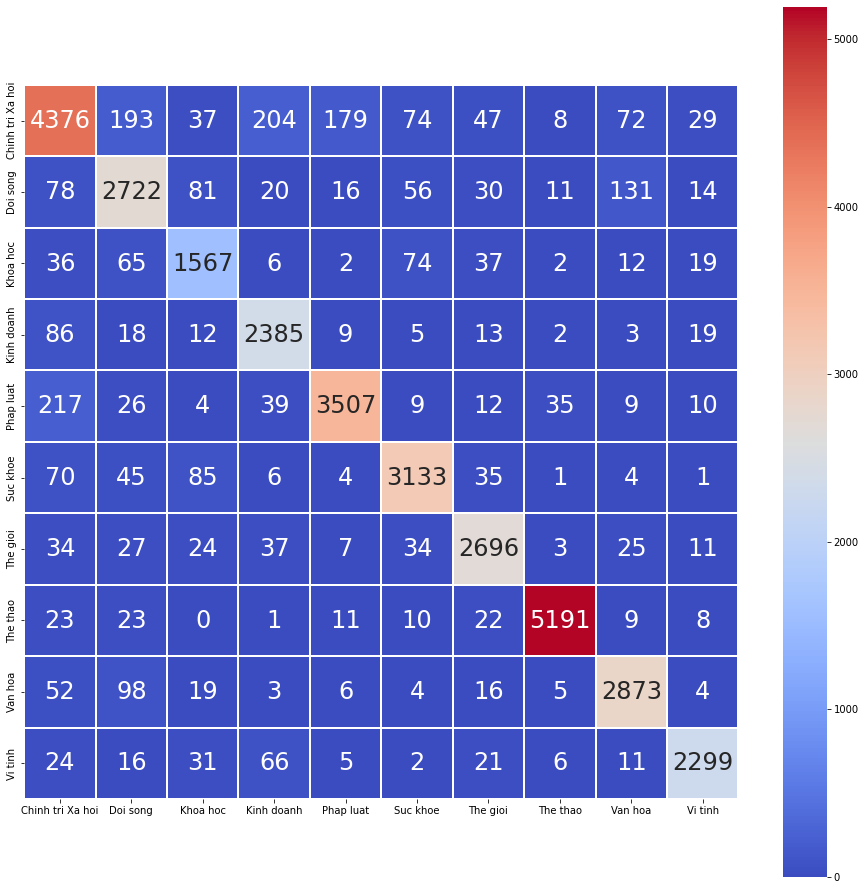

In [ ]:
# Tính Confusion matrix
cf = confusion_matrix(test_labels_encoded, y_pred)
print(cf)

# Tính F1 micro
eval_micro = f1_score(test_labels_encoded, y_pred, average='micro')
print("F1 - micro: " + str(eval_micro))

# Tính F1 macro
eval_macro = f1_score(test_labels_encoded, y_pred, average='macro')
print("F1 - macro: " + str(eval_macro))

# Tính Accuracy score
acc_sc = accuracy_score(test_labels_encoded, y_pred)
print("Accuracy: " + str(acc_sc))

# Hiển thị Confusion matrix
df_cm = pd.DataFrame(cf, index = label_encoder.classes_,
        columns = label_encoder.classes_)
plt.subplots(figsize=(16, 16))
sn.heatmap(df_cm, annot=True, cmap="coolwarm",fmt='d', linewidths = 1, cbar=True, square = True, annot_kws={"size": 24})